# Estimating COVID-19's $R_t$ in Real-Time

> Original code by Kevin Systrom - April 17 ( *translated into Julia by Hugh Murrell April 2020* )

> Simplification to direct computation of $R_t$ without Baise by Hugh Murrell May 2020

In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) changes $R_t$. Knowing the current $R_t$ is essential. When $R\gg1$, the pandemic will spread through a large part of the population. If $R_t<1$, the pandemic will slow quickly before it has a chance to infect many people. The lower the $R_t$: the more manageable the situation. In general, any $R_t<1$ means things are under control.

The value of $R_t$ helps us in two ways. (1) It helps us understand how effective our measures have been controlling an outbreak and (2) it gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.


# Application to UK Data

We load UK case data using this link:

https://coronavirus.data.gov.uk/downloads/csv/coronavirus-cases_latest.csv

and then we filter the data, county by county, removing sections with missing data or zero new case counts.

We need to start the analysis when there are a consistent number of cases each day.

Also, case reporting is very erratic based on testing backlogs, etc. We apply a filter to the time series. The real world process is not nearly as stochastic as the actual reporting.

In [1]:
using StatsBase, Distributions, Plots, DataFrames, CSV, Dates, HTTP, Impute, DSP;
# some model parameters that will be used throughout this notebook
IFP = 7   # infectious period in days
GAMMA = 1/IFP  # recovery rate
SMOOTHING_PASSES = 3 # number of times to apply moving average filter to case data
INF_CUTOFF = 0.02
ONSET_DELAY = 4  # default onset delayin days, might get changed later
println("IFP=",IFP," GAMMA=",GAMMA," SMOOTHING_PASSES=",
    SMOOTHING_PASSES," INF_CUTOFF=",INF_CUTOFF," ONSET_DELAY=",ONSET_DELAY)

IFP=7 GAMMA=0.14285714285714285 SMOOTHING_PASSES=3 INF_CUTOFF=0.02 ONSET_DELAY=4


In [23]:
url="https://coronavirus.data.gov.uk/downloads/csv/coronavirus-cases_latest.csv"
full_data = CSV.read(IOBuffer(HTTP.get(url).body))
println(names(full_data))
data=DataFrame(full_data[:,1:5])
rename!(data,Symbol.(["location","code","type","date","new_cases"]))
println("table read, size = ",size(data))
# date = Symbol("Specimen date")
println("latest counts on ",maximum(data[:,:date]))

Symbol[Symbol("Area name"), Symbol("Area code"), Symbol("Area type"), Symbol("Specimen date"), Symbol("Daily lab-confirmed cases"), Symbol("Previously reported daily cases"), Symbol("Change in daily cases"), Symbol("Cumulative lab-confirmed cases"), Symbol("Previously reported cumulative cases"), Symbol("Change in cumulative cases"), Symbol("Cumulative lab-confirmed cases rate")]
table read, size = (31752, 5)
latest counts on 2020-05-24


In [24]:
println(union(data[:,:type]))

["Nation", "Region", "Upper tier local authority", "Lower tier local authority"]


In [25]:
println(sort(union(data[data[:,:type].=="Region",:location])))

["East Midlands", "East of England", "London", "North East", "North West", "South East", "South West", "West Midlands", "Yorkshire and The Humber"]


In [4]:
println(sort(union(data[data[:,:type].=="Upper tier local authority",:location])))

["Barking and Dagenham", "Barnet", "Barnsley", "Bath and North East Somerset", "Bedford", "Bexley", "Birmingham", "Blackburn with Darwen", "Blackpool", "Bolton", "Bournemouth, Christchurch and Poole", "Bracknell Forest", "Bradford", "Brent", "Brighton and Hove", "Bristol, City of", "Bromley", "Buckinghamshire", "Bury", "Calderdale", "Cambridgeshire", "Camden", "Central Bedfordshire", "Cheshire East", "Cheshire West and Chester", "City of London", "Cornwall and Isles of Scilly", "County Durham", "Coventry", "Croydon", "Cumbria", "Darlington", "Derby", "Derbyshire", "Devon", "Doncaster", "Dorset", "Dudley", "Ealing", "East Riding of Yorkshire", "East Sussex", "Enfield", "Essex", "Gateshead", "Gloucestershire", "Greenwich", "Hackney", "Halton", "Hammersmith and Fulham", "Hampshire", "Haringey", "Harrow", "Hartlepool", "Havering", "Herefordshire, County of", "Hertfordshire", "Hillingdon", "Hounslow", "Isle of Wight", "Islington", "Kensington and Chelsea", "Kent", "Kingston upon Hull, City 

In [5]:
data = vcat( data[data[:,:type].=="Upper tier local authority",:], data[data[:,:type].=="Nation",:] )

,location,code,type,date,new_cases
,String,String,String,Date,Float64⍰
1,Worcestershire,E10000034,Upper tier local authority,2020-05-20,0.0
2,West Sussex,E10000032,Upper tier local authority,2020-05-20,0.0
3,Warwickshire,E10000031,Upper tier local authority,2020-05-20,0.0
4,Surrey,E10000030,Upper tier local authority,2020-05-20,0.0
5,Suffolk,E10000029,Upper tier local authority,2020-05-20,1.0
6,Staffordshire,E10000028,Upper tier local authority,2020-05-20,1.0
7,Somerset,E10000027,Upper tier local authority,2020-05-20,0.0
8,Oxfordshire,E10000025,Upper tier local authority,2020-05-20,0.0
9,Nottinghamshire,E10000024,Upper tier local authority,2020-05-20,2.0


### Adjustment for reporting delay

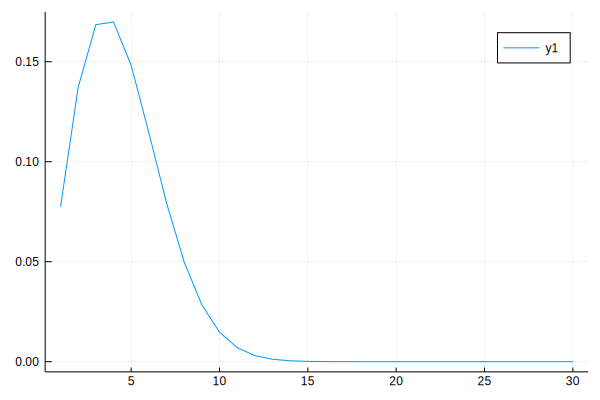

In [6]:
adj_range = collect(1:1:30)
p_delay = [pdf.(Weibull(2, 5),t) for t in adj_range]
p_delay = p_delay ./ sum(p_delay)
plot(adj_range, p_delay)

In [7]:
function estimate_onset(new_cases, p_delay)
    return reverse(conv(reverse(new_cases),p_delay))[length(p_delay):end]
end

estimate_onset (generic function with 1 method)

In [8]:
function adjust_onset(onset, p_delay)
    c_delay = cumsum(p_delay)
    extras = length(onset) - length(c_delay)
    if (extras > 0)
        cd = vcat(c_delay,ones(extras))
        adjusted = onset ./ reverse(cd)
    else
        adjusted = onset
    end
    return adjusted[1:end]
end

adjust_onset (generic function with 1 method)

In [9]:
function moving_average(inf; alpha=0.5)
    vs = inf
    if length(vs) > 1
        ret = 
            # vcat( vs[1], [ alpha * vs[i] + (1 - alpha)*vs[i-1] for i = 2:length(vs) ] )
            vcat((vs[1]+2*vs[1])/3,
                   [sum(@view vs[i:(i+2)])/3 for i in 1:(length(vs)-(2))],
                    (2*vs[length(vs)]+vs[length(vs)])/3)
    else
        ret = vs
    end
    return ret
    return Int64.(round.(ret))
end

moving_average (generic function with 1 method)

In [10]:
function compute_infectives(new_cases) 
    onset = estimate_onset(new_cases,p_delay)
    adj_onset = adjust_onset(onset,p_delay)
    if length(adj_onset) >= IFP
       infects = [sum(adj_onset[i-IFP+1:i])
                        for i in IFP:length(adj_onset) ] 
    else
        infects = []
    end
    return infects
end

compute_infectives (generic function with 1 method)

In [11]:
function process_data(data)
    nz = copy(data[data[:,:date] .> Date(2020,2,23),:])
    sort!(nz,:date)
    nz[ismissing.(nz[:,:new_cases]),:new_cases] .= 0
    nz[:,:cases] = Float64.(cumsum(nz[:,:new_cases])) 
    allowmissing!(nz)
    # now insert missing dates and impute cumulative cases for those dates
    if size(nz)[1] > 1
        dr = nz[1,:date]:Day(1):nz[end,:date]
        for d in dr
            if ! (d in nz[:,:date])
                push!(nz,[missing for i in 1:size(nz)[2]])
                nz[end,:location] = nz[end-1,:location]
                nz[end,:date] = d
            end
        end
        sort!(nz,:date)
        nz[!,:cases] = Impute.interp(nz[:,:cases])
    end
    smooth_new_cases = diff(nz[:,:cases])
    for i in 1:SMOOTHING_PASSES
        smooth_new_cases = moving_average(smooth_new_cases)
    end
    # nz[:,:new_cases] = Int64.(round.(smooth_new_cases))
    infectives = compute_infectives(smooth_new_cases)
    nz = nz[IFP+1:end,:]
    nz[:,:infectives] = Float64.(infectives)
    return nz   
end        

process_data (generic function with 1 method)

(69, 7)
min = missing max = missing latest data at 2020-05-20


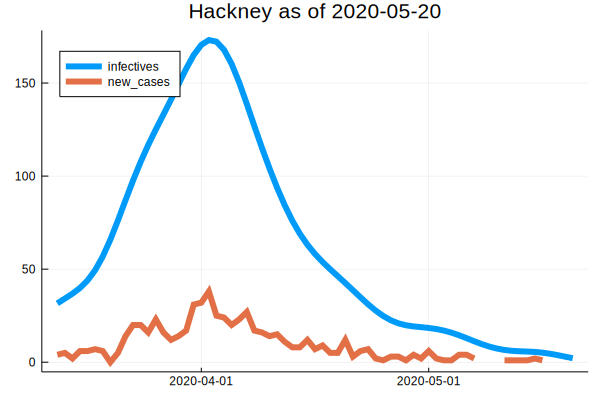

In [12]:
countries = unique(data[:,:location])
country = "Hackney"
country_data = data[data[:,:location].==country,:]
country_data_filtered = process_data(country_data)
println(size(country_data_filtered))
end_date = country_data_filtered[:,:date][end]
println("min = ",minimum(country_data_filtered[:,:new_cases]), 
        " max = ",maximum(country_data_filtered[:,:new_cases]),
        " latest data at ",end_date)
plot(country_data_filtered[:,:date], 
    [country_data_filtered[:,:infectives], country_data_filtered[:,:new_cases]], lw=6,
    legend=:topleft,
    labels=["infectives" "new_cases"],
    title="$country as of $end_date")

Putting all this into one function

In [13]:
function strip_leading_zero_case_counts(data)
    nz = copy(data)
    nc = nz[:,:new_cases]
    ind = 1
    while (ind <= length(nc) && nc[ind]==0)
        ind+=1
    end
    if (ind != 1)
        nz = copy(nz[ind:end,:])
    end
    return(nz)
end

strip_leading_zero_case_counts (generic function with 1 method)

In [14]:
function prepare_cases(full_data, country)
    country_data = full_data[full_data[:,:location].==country,:]
    country_data = strip_leading_zero_case_counts(country_data)
    if size(country_data)[1] < 30  # need at least one month of case counts
        return (country_data, false)
    end
    country_data_filtered = process_data(country_data)
    sanity_check=true
    if (ismissing(minimum(country_data_filtered[:,:infectives])) ||
        minimum(country_data_filtered[:,:infectives])< 0)
        sanity_check = false
    end
    return (country_data_filtered, sanity_check)
end

prepare_cases (generic function with 1 method)

sane = true


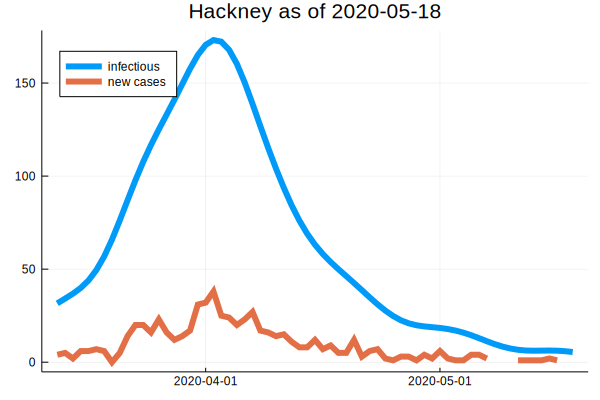

In [15]:
df,sane = prepare_cases(data,country)
println("sane = ",sane)
end_date = df[end,:date]
plot(df[:,:date], [df[:,:infectives], df[:,:new_cases]], lw=6,
    legend=:topleft,
    labels=["infectious" "new cases"],
    title="$country as of $end_date")

#### Now lets try and produce current most likely Rt for each country with enough case data

In [16]:
function estimate_rt(data)
    infectives = data[:,:infectives]
    # instantaneous Rt estimate
    rt_est = [ 1 + IFP * ((infectives[i+1]-infectives[i])/(infectives[i])) 
                            for i in 1:length(infectives)-1]
    # apply low Rt cutoff 
    for i in 1:length(rt_est)
        max_inf = maximum(infectives[1:i])
        if (( infectives[i]/max_inf < INF_CUTOFF ) || rt_est[i]<0 )
            rt_est[i] = 0
        end
    end
    # sanity check
    sane = true
    last_week = rt_est[end-6:end]
    if maximum(last_week)-minimum(last_week) > 2
        sane = false
        println("something fishy...")
    end
    data = data[1:end-1,:]
    data[!,:rt_est] = rt_est
    # throw away the last ONSET_DELAY data
    data = data[1:end-ONSET_DELAY+1,:]
    return (data,sane)
end     

estimate_rt (generic function with 1 method)

In [17]:
output_url = "./"
countries = sort(unique(data[:,:location]))
df = DataFrame(country=String[], start_date=Date[],end_date=Date[], est_date=Date[],
                    rt=Float64[],irat=Float64[],rank=Float64[])
for country in countries
    dc,sane = prepare_cases(data,country)
    if ( ! sane ) 
        println("skipping $country ... sanity check is $sane")
    else
        infectives = dc[:,:infectives]
        if ( length(infectives)<10 || maximum(infectives) < 100)
            println("skipping $country ... not enough data")
        else
            println("processing $country ...")
            start_date = dc[1,:date]  
            end_date = dc[end,:date]
            # calculate ratio of last I(t) to maximum of all I(t)s
            irat = round(infectives[end]/maximum(infectives),digits=2)
            inf_score = Int64(round(
                    100*(infectives[end]-infectives[end-ONSET_DELAY])/infectives[end-ONSET_DELAY],
                digits=0))
            up_down=""
            if inf_score > 0
                up_down = "up"
            else
                up_down = "down"
                inf_score = - inf_score
            end
            fig = plot(dc[:,:date], [dc[:,:infectives], dc[:,:new_cases]], lw=6,
                    legend=:topleft,
                    label=[ "infectious" "new_cases" ],
                    title="$country, infectious pool $inf_score% $up_down by $end_date")
            savefig(output_url*"plots/Inf_$country")
        
            # now use helpter to compute rt estimates
            dc,sane = estimate_rt(dc)
            if (! sane)
                println("skipping $country ... Rt estimation failed")
            else
                est_date = dc[end,:date]
                # make an Rt plot for this country
                rt_score = round(sum(dc[end,:rt_est]),digits=2)
            # cdf = DataFrame(date = dates[2:end], rt = rt_est)
                fig = plot(dc[:,:date], dc[:,:rt_est], 
                        lw = 3, label = "Rt estimate",
                        m=:circle, ms=6, ylimits=[-0.5,5.5],
                        title="$country, R(t) = $rt_score at $est_date")
                plot!(dc[:,:date], ones(size(dc)[1]),lw=3,label="R(t)=1")
                savefig(output_url*"plots/Rt_$country")
                # now save last mlrt, low, high, irat and rank
                rank = round(rt_score * irat, digits=2)
                push!(df,[country start_date end_date est_date rt_score irat rank])
            end
        end
    end
end
df

processing Barking and Dagenham ...
processing Barnet ...
processing Barnsley ...
skipping Bath and North East Somerset ... not enough data
processing Bedford ...
processing Bexley ...
processing Birmingham ...
skipping Blackburn with Darwen ... not enough data
processing Blackpool ...
processing Bolton ...
processing Bournemouth, Christchurch and Poole ...
skipping Bracknell Forest ... not enough data
processing Bradford ...
processing Brent ...
skipping Brighton and Hove ... not enough data
processing Bristol, City of ...
processing Bromley ...
processing Buckinghamshire ...
processing Bury ...
skipping Calderdale ... not enough data
processing Cambridgeshire ...
processing Camden ...
processing Central Bedfordshire ...
processing Cheshire East ...
processing Cheshire West and Chester ...
skipping City of London ... sanity check is false
processing Cornwall and Isles of Scilly ...
processing County Durham ...
processing Coventry ...
processing Croydon ...
processing Cumbria ...
skipp

,country,start_date,end_date,est_date,rt
,String,Date,Date,Date,Float64
1,Barking and Dagenham,2020-03-08,2020-05-18,2020-05-14,0.65
2,Barnet,2020-03-06,2020-05-19,2020-05-15,0.68
3,Barnsley,2020-03-09,2020-05-19,2020-05-15,0.46
4,Bedford,2020-03-20,2020-05-17,2020-05-13,0.87
5,Bexley,2020-03-16,2020-05-19,2020-05-15,0.47
6,Birmingham,2020-03-08,2020-05-19,2020-05-15,0.1
7,Blackpool,2020-03-17,2020-05-19,2020-05-15,0.34
8,Bolton,2020-03-08,2020-05-19,2020-05-15,0.71
9,"Bournemouth, Christchurch and Poole",2020-03-12,2020-05-19,2020-05-15,1.03


In [18]:
dft = df
sort!(dft,:country)
CSV.write(output_url*"data/ranking_alpha.csv",dft)
sort!(dft,:rank)
CSV.write(output_url*"data/ranking_rtirat.csv",dft)
sort!(dft,:rt)
CSV.write(output_url*"data/ranking_rt.csv",dft)

"./data/ranking_rt.csv"

In [19]:
last(dft,10)

,country,start_date,end_date,est_date,rt,irat,rank
,String,Date,Date,Date,Float64,Float64,Float64
1,Hackney,2020-03-13,2020-05-18,2020-05-14,1.05,0.03,0.03
2,Waltham Forest,2020-03-12,2020-05-19,2020-05-15,1.05,0.04,0.04
3,Surrey,2020-03-03,2020-05-18,2020-05-14,1.05,0.12,0.13
4,Lewisham,2020-03-11,2020-05-19,2020-05-15,1.06,0.06,0.06
5,Hammersmith and Fulham,2020-03-11,2020-05-18,2020-05-14,1.08,0.06,0.06
6,Enfield,2020-03-13,2020-05-19,2020-05-15,1.13,0.06,0.07
7,Merton,2020-03-08,2020-05-18,2020-05-14,1.33,0.07,0.09
8,Middlesbrough,2020-03-21,2020-05-19,2020-05-15,1.6,0.11,0.18
9,Bury,2020-03-08,2020-05-18,2020-05-14,1.65,0.36,0.59


In [20]:
maximum(dft[:,:end_date])

2020-05-20

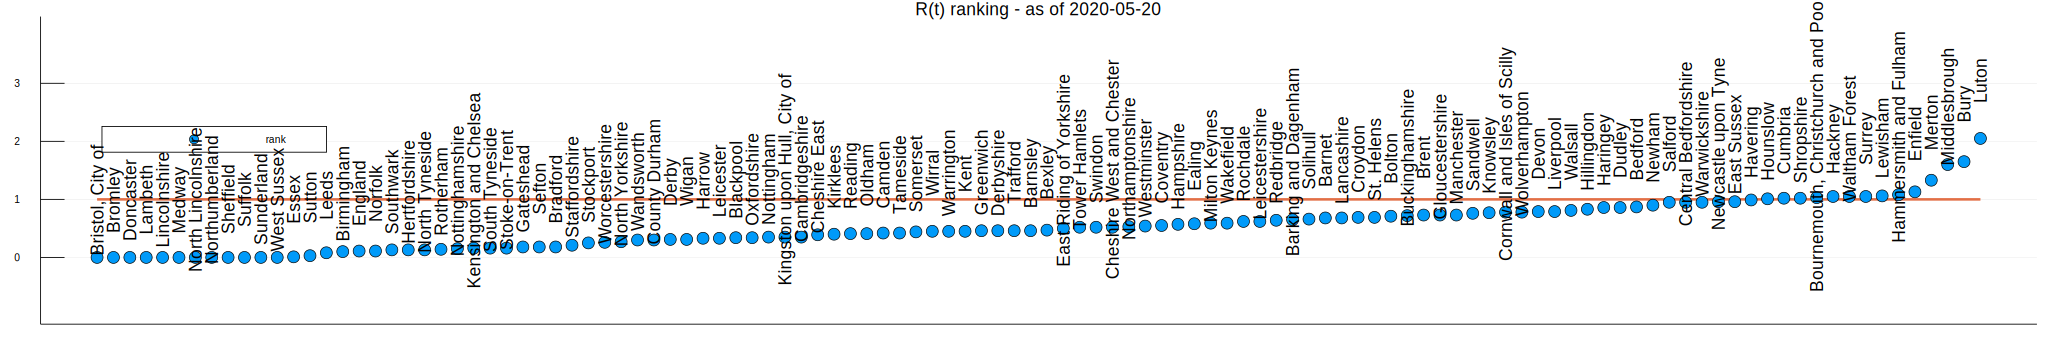

In [21]:
Plots.Font("sans-serif", 10, :hcenter, :center, 0.0, RGB(0.0,0.0,0.0))
myfont = text("").font
myfont.rotation = 90
end_date = maximum(dft[:,:end_date])
fig = plot()
# fig = scatter( (dft[:,:high]+dft[:,:low])/2, 
#     yerror = (dft[:,:high]-dft[:,:low])/2, c=3,
#     m = :circle, ms = 0, markerstrokewidth = 2, label="")
plot!(ones(size(dft)[1]),label="",c=2, lw=3,    
    title="R(t) ranking - as of $end_date")
scatter!(dft[:,:rt],markershape=:circle,   
    markersize = 8, c=1, 
    ylims=[-1, 4], yticks = [0.0, 1.0, 2.0, 3.0], xticks = [],
    # series_annotations=text.(dft[:,:country], :middle, 6, :hcenter, :vcenter),
    size=(2400,400),
    label="rank", legend=:topleft)
for j in 1:size(dft)[1]
    annotate!(j,dft[:,:rt][j]+1, dft[:,:country][j], myfont)
end
savefig("plots/ranking")
fig